**Created on 05/01/2022**

**Group 2**

**Authors: LaurianeBompay**

**License: this code is released under the CeCILL 2.1 license. See
https://www.cecill.info/licenses/Licence_CeCILL_V2.1-en.txt**


In [233]:
import os
import sys
import math
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

In [234]:
sns.set_style('darkgrid')

In [319]:
#data importation 
data_1 = pd.read_csv("newData.csv", index_col = 0)
#data_0 = pd.read_csv("positions.csv")

Il faudra changer l'imporation des données quand on aura le jeu de données avec les changements de repaires.

## <center>Remplacement des -inf</center>

In [320]:
data_1.replace([-np.inf], -120, inplace=True)

Les -inf sont dans les rssi et indique que le signal est très mauvais (ce n'est pas un nan) donc on remplace par -120 car c'est la valeur qui indique un mauvais signal (voir la doc sur les rssi)

In [321]:
data_1.describe()

,target,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,...,course_dist,temperature_initiator,temperature_target,timestamp,seqnum,rssi_request,rssi_ack,rssi_data,rssi_mean,repaire
count,19730.000000,19730.000000,1.973000e+04,1.973000e+04,1.973000e+04,1.973000e+04,19730.000000,19730.000000,19730.000000,19730.000000,...,19730.000000,19730.000000,19730.000000,1.973000e+04,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000,19730.000000
mean,148.315256,7.215384,5.505930e+11,5.509284e+11,5.510320e+11,5.506966e+11,-2.755970,999.946275,1142.269047,4.690093,...,3.617079,39.577380,39.555326,1.654930e+12,2200.960720,-81.090100,-80.970815,-80.836828,-81.005838,106.200000
std,35.801496,19.474280,3.164088e+11,3.164091e+11,3.164091e+11,3.164088e+11,3.762077,674.275845,646.644922,3.162586,...,2.026579,2.341626,3.781826,3.017622e+05,1216.021329,5.635227,5.072462,4.817778,5.385790,61.171477
min,100.000000,0.000000,6.062043e+07,2.633300e+08,3.679996e+08,1.652910e+08,-11.659438,-613.000000,-152.480214,-2.875181,...,0.000000,30.410000,27.559999,1.654930e+12,1.000000,-120.000000,-120.000000,-120.000000,-120.000000,0.000000
25%,101.000000,2.956454,2.778599e+11,2.782487e+11,2.783513e+11,2.779625e+11,-5.783573,655.000000,715.849019,3.072176,...,1.899738,38.959999,36.680000,1.654930e+12,1174.000000,-79.967224,-79.988684,-79.884079,-79.886929,100.000000
50%,171.000000,3.524929,5.528798e+11,5.532044e+11,5.533074e+11,5.529824e+11,-1.784294,898.000000,998.316717,4.211930,...,3.699628,40.384998,39.340000,1.654930e+12,2231.500000,-79.230034,-79.305238,-79.218111,-79.237715,101.000000
75%,180.000000,4.342597,8.239225e+11,8.243395e+11,8.244432e+11,8.240262e+11,0.338401,1222.000000,1355.550936,5.731602,...,5.399282,41.240002,42.380001,1.654931e+12,3252.000000,-78.659592,-78.701023,-78.666953,-78.686635,150.000000
max,184.000000,342.462982,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2636.000000,2860.190262,12.363750,...,6.999961,42.380001,47.320004,1.654931e+12,4260.000000,-77.162437,-77.516188,-77.428716,-77.478065,180.000000


## <center>Test du modèle random forest pour determiner le position</center>

### Selection des variables pour la prédiction de position

In [397]:
data_for_pred = data_1.drop(['target',
                             'range',
                             'range_skew',
                             'ranging_error',
                             'distance',
                             'loc_target_z',
                             'timestamp',
                             'course_dist',
                             'temperature_initiator',
                             'temperature_target',
                             'seqnum'],axis=1, inplace=False)

On supprime course_dist car c'est équivalent à la localisation

In [398]:
var = data_for_pred.columns.to_list()
y=data_for_pred[['loc_initiator_x','loc_initiator_y']]

In [415]:
#ceration of test and train
test,train = train_test_split(data_for_pred, test_size=0.3, train_size=0.7, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [416]:
X_train.describe()

,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,loc_target_x,loc_target_y,rssi_request,rssi_ack,rssi_data,rssi_mean,repaire
count,5919.000000,5.919000e+03,5.919000e+03,5.919000e+03,5.919000e+03,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000,5919.000000
mean,7.504284,5.546825e+11,5.550187e+11,5.551223e+11,5.547861e+11,-2.741404,1004.213550,1145.789615,-0.965415,-0.853090,-81.139981,-80.998792,-80.879298,-81.036701,106.717520
std,20.168912,3.158573e+11,3.158558e+11,3.158558e+11,3.158573e+11,3.746195,676.578235,651.791452,8.123395,4.733176,5.661280,5.010859,4.859161,5.336994,61.282337
min,0.000000,6.062043e+07,2.633300e+08,3.679996e+08,1.652910e+08,-11.659438,-613.000000,-152.480214,-15.404000,-9.249000,-120.000000,-120.000000,-120.000000,-120.000000,0.000000
25%,2.947936,2.822200e+11,2.826866e+11,2.827893e+11,2.823228e+11,-5.752810,636.000000,710.157539,-7.359000,-4.671000,-79.980904,-80.006742,-79.884079,-79.886662,100.000000
50%,3.536684,5.619592e+11,5.622853e+11,5.623891e+11,5.620621e+11,-1.784294,901.000000,999.263503,-0.830000,-1.546000,-79.230507,-79.320397,-79.232468,-79.253947,101.000000
75%,4.389418,8.240644e+11,8.243547e+11,8.244584e+11,8.241682e+11,0.369164,1222.500000,1363.346112,5.252000,3.318000,-78.665154,-78.716261,-78.667944,-78.690827,150.000000
max,342.462982,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2636.000000,2860.190262,15.404000,9.249000,-77.162437,-77.516188,-77.428716,-77.478065,180.000000


#### Premier modele avec toutes les variables

In [417]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf=reg.predict(X_test)

In [418]:
reg.score(X_test,Y_test)

0.9781751463082673

In [419]:
mean_squared_error(Y_test,predic_rf)

0.3622640889305944

#### Affichage de ce premier modele

In [420]:
predic_position = pd.DataFrame(predic_rf, columns=['loc_initiator_x','loc_initiator_y'])

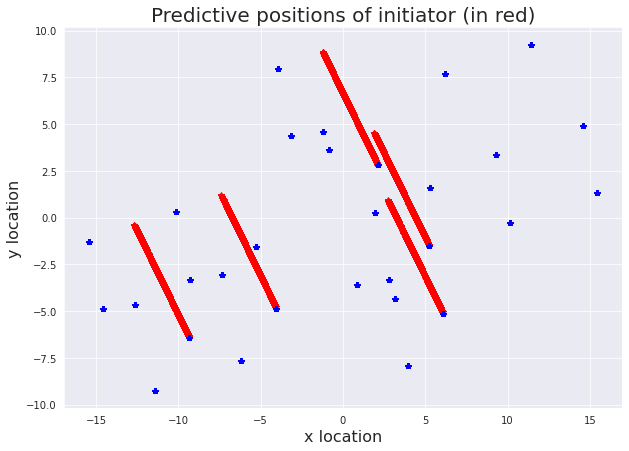

In [421]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position['loc_initiator_x'],predic_position['loc_initiator_y'],'*r')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b")
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.title('Predictive positions of initiator (in red)', fontsize=20);

In [422]:
from sklearn.metrics import accuracy_score
list_variable=['nlos_indicator',
 't1',
 't2',
 't3',
 't4',
 'skew',
 'tof',
 'tof_skew',
 'loc_target_x',
 'loc_target_y',
 'rssi_request',
 'rssi_ack',
 'rssi_data',
 'rssi_mean',
 'repaire']
list_variable_tabou=list_variable
variable=[]
score=0
data_for_pred=data_for_pred.sample(frac=1).reset_index(drop=True)
while len(list_variable_tabou)>0:
    y=data_for_pred[['loc_initiator_x','loc_initiator_y']]
    variable_en_cour=False
    for i in list_variable_tabou:
        X=data_for_pred[variable+[i]]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        clf = RandomForestRegressor()
        clf= clf.fit(x_train, y_train)
        score_test=clf.score(x_test,y_test)
    if score_test>score:
        score=score_test
        variable_en_cour=i
    if variable_en_cour==False:
        list_variable_tabou=[]
    else:
        variable.append(variable_en_cour)
        del list_variable_tabou[list_variable_tabou.index(variable_en_cour)]
    print(variable_en_cour,score)

repaire 0.8743521701240831
False 0.8743521701240831


Cet algo me dit qu'il faut garder juste repaire mais ça semble faux

In [405]:
reg = RandomForestRegressor()
sfs = SequentialFeatureSelector(reg)
sfs.fit(X_train, Y_train)

SequentialFeatureSelector(estimator=RandomForestRegressor())

In [406]:
var_select = sfs.get_support()
list_variable = X_train.columns.to_list()
for i in range(len(list_variable)) :
    if var_select[i]:
        print(list_variable[i])

nlos_indicator
skew
tof
tof_skew
loc_target_y
rssi_data
rssi_mean


#### Deuxième modèle avec les variables sélectionnées : nlos_indicator, skew, tof, tof_skew, loc_target_y, rssi_data,rssi_mean

In [429]:
#ceration of test and train with selected variables
test,train = train_test_split(data_for_pred[['nlos_indicator',
                                             'skew',
                                             'tof',
                                             'tof_skew',
                                             'loc_target_y',
                                             'rssi_data',
                                             'rssi_mean',
                                             'loc_initiator_x',
                                             'loc_initiator_y']], test_size=0.3, train_size=0.7, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [430]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf=reg.predict(X_test)
reg.score(X_test,Y_test)

0.9800473344776849

In [431]:
mean_squared_error(Y_test,predic_rf)

0.3387936230734926

In [434]:
predic_position_2 = pd.DataFrame(predic_rf, columns=['loc_initiator_x','loc_initiator_y'])

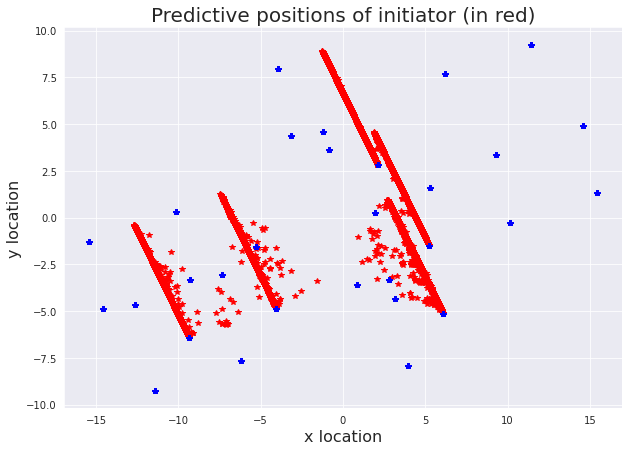

In [435]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position_2['loc_initiator_x'],predic_position_2['loc_initiator_y'],'*r')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b")
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.title('Predictive positions of initiator (in red)', fontsize=20);

### Validation croisée

In [424]:
Y = data_for_pred[['loc_initiator_x', 'loc_initiator_y']]
X = data_for_pred.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [425]:
reg = RandomForestRegressor()
cross_val_score(reg, X, Y, cv=5)

array([0.983855  , 0.98379606, 0.98349805, 0.98401519, 0.98640197])